In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
from concurrent.futures import ThreadPoolExecutor
import concurrent

In [12]:
# load dataset
df = None

def read_csv(url):
    return pd.read_csv(url)

# with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
#     future_list = []

#     for index in range(1, 13):
#         future = executor.submit(read_csv, f"datasets/airline_arrival_delays/t{index}.csv")
#         future_list.append(future)

#     for future in future_list:
#         try:
#             result = future.result(timeout=10)
#             if df is None:
#                 df = result
#             else:
#                 print(123)
#                 df = df.append(result)
#             print(result.shape)
# #             results.append(result)
#         except Exception as e:
#             print("Cannot load", e)

                    
df = pd.read_csv("datasets/airline_arrival_delays/AirlineData.csv")

In [13]:
old_columns = df.columns

# convert column names to Pascal case
for old_column in old_columns:
    new_column = "".join([segment.lower().capitalize() for segment in old_column.split("_")])
    df[new_column] = df[old_column]

df = df.drop(old_columns, axis=1)

In [14]:
df

,Year,Month,DayOfMonth,DayOfWeek,OpUniqueCarrier,TailNum,OpCarrierFlNum,Origin,Dest,CrsDepTime,...,CrsElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,CarrierDelay,WeatherDelay,NasDelay,SecurityDelay,LateAircraftDelay
0,2020,1,17,5,WN,N7736A,458,LAS,MDW,845,...,205.0,189.0,171.0,1.0,1521.0,NaN,NaN,NaN,NaN,NaN
1,2020,1,17,5,WN,N961WN,1469,LAS,MDW,550,...,200.0,184.0,172.0,1.0,1521.0,NaN,NaN,NaN,NaN,NaN
2,2020,1,17,5,WN,N8667D,1486,LAS,MDW,1355,...,215.0,NaN,NaN,1.0,1521.0,NaN,NaN,NaN,NaN,NaN
3,2020,1,17,5,WN,N567WN,1728,LAS,MDW,1640,...,205.0,NaN,NaN,1.0,1521.0,NaN,NaN,NaN,NaN,NaN
4,2020,1,17,5,WN,N8525S,1744,LAS,MDW,740,...,205.0,206.0,181.0,1.0,1521.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607341,2020,1,16,4,9E,N902XJ,4816,PWM,LGA,600,...,101.0,172.0,57.0,1.0,269.0,0.0,0.0,65.0,0.0,0.0
607342,2020,1,17,5,9E,N293PQ,4816,PWM,LGA,600,...,101.0,91.0,69.0,1.0,269.0,23.0,0.0,0.0,0.0,0.0
607343,2020,1,18,6,9E,N325PQ,4816,PWM,LGA,700,...,100.0,73.0,55.0,1.0,269.0,NaN,NaN,NaN,NaN,NaN
607344,2020,1,19,7,9E,N228PQ,4816,PWM,LGA,700,...,102.0,136.0,54.0,1.0,269.0,0.0,0.0,39.0,0.0,0.0


In [15]:
# we first ignore the canceled flights because we only predict the flights are late or not
# df = df[df["Cancelled"] == False]
# because we only classify whether the flight is late or not, so we have to drop the other delay columns
df = df.drop(["CarrierDelay",
              "WeatherDelay",
              "NasDelay",
              "SecurityDelay",
              "LateAircraftDelay",
              "Cancelled",
              "CancellationCode",
              # flights feature doesn't seem to have any meaning
              "Flights"], axis=1)

# define label for dataset
df["IsLate"] = df["ArrDelay"].apply(lambda x: x > 30)
# besides, there are no reason to keep ArrTime and ArrDelay anymore, they don't have any specific role in this requirements
# and can potentially harm the model's result
df = df.drop(["ArrTime", "ArrDelay"], axis=1)

## Exploratory Data Analysis

In [16]:
# after filtering unnecessary columns, we now have only 21 features and 1 label
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607346 entries, 0 to 607345
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               607346 non-null  int64  
 1   Month              607346 non-null  int64  
 2   DayOfMonth         607346 non-null  int64  
 3   DayOfWeek          607346 non-null  int64  
 4   OpUniqueCarrier    607346 non-null  object 
 5   TailNum            606648 non-null  object 
 6   OpCarrierFlNum     607346 non-null  int64  
 7   Origin             607346 non-null  object 
 8   Dest               607346 non-null  object 
 9   CrsDepTime         607346 non-null  int64  
 10  DepTime            600682 non-null  float64
 11  DepDelay           600647 non-null  float64
 12  TaxiOut            600524 non-null  float64
 13  TaxiIn             600271 non-null  float64
 14  CrsArrTime         607346 non-null  int64  
 15  Diverted           607346 non-null  float64
 16  Cr

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,607346.0,2020.000000,0.000000,2020.0,2020.0,2020.0,2020.0,2020.0
Month,607346.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
DayOfMonth,607346.0,16.014354,8.990719,1.0,8.0,16.0,24.0,31.0
DayOfWeek,607346.0,3.955735,1.910205,1.0,2.0,4.0,5.0,7.0
OpCarrierFlNum,607346.0,2622.365261,1822.545302,1.0,1070.0,2177.0,4108.0,6860.0
CrsDepTime,607346.0,1329.904284,488.833507,2.0,917.0,1324.0,1735.0,2359.0
DepTime,600682.0,1331.512559,497.095168,1.0,919.0,1326.0,1739.0,2400.0
DepDelay,600647.0,6.181221,43.181905,-58.0,-6.0,-3.0,2.0,2489.0
TaxiOut,600524.0,17.356615,9.622261,1.0,11.0,15.0,20.0,189.0
TaxiIn,600271.0,7.503138,5.670835,1.0,4.0,6.0,9.0,146.0


In [18]:
df.describe(include="O")

,OpUniqueCarrier,TailNum,Origin,Dest
count,607346,606648,607346,607346
unique,17,5444,351,350
top,WN,N488HA,ATL,ATL
freq,109770,333,32190,32187


## All columns and their description

1. Year: ~~ 1987-2008 ---- Year doesn't tell any story.
2. Month: ~~ 1-12
3. DayofMonth: ~~ 1-31
4. DayOfWeek: ~~ 1 (Monday) - 7 (Sunday)
5. DepTime: ~~ actual departure time (local, hhmm)
6. CRSDepTime: ~~ scheduled departure time (local, hhmm)
7. ArrTime: ~~ actual arrival time (local, hhmm)
8. CRSArrTime: ~~ scheduled arrival time (local, hhmm)
9. UniqueCarrier: ~~ unique carrier code
10. FlightNum: ~~ flight number
11. TailNum: ~~ plane tail number
12. ActualElapsedTime: ~~ in minutes
13. CRSElapsedTime: ~~ in minutes ------ __have negative number__
14. AirTime: ~~ in minutes
15. ArrDelay: ~~ arrival delay, in minutes
16. DepDelay: ~~ departure delay, in minutes ------ __have negative number__
17. Origin: ~~ origin IATA airport code
18. Dest: ~~ destination IATA airport code
19. Distance: ~~ in miles
20. TaxiIn: ~~ taxi in time, in minutes
21. TaxiOut: ~~ taxi out time in minutes
22. Cancelled: ~~ was the flight cancelled?
23. CancellationCode: ~~ reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24. Diverted: ~~ 1 = yes, 0 = no
25. CarrierDelay: ~~ in minutes
26. WeatherDelay: ~~ in minutes
27. NASDelay: ~~ in minutes
28. SecurityDelay: ~~ in minutes
29. LateAircraftDelay: ~~ in minutes

---

__Taxi-in definition:__ Pre-enter the airport's operations (call gate agents to open the gate, ground crew to clear everything out of the way, ...)

_Description:_ Just a couple of minutes and you will finally be getting into the gate! While your pilots taxi in to your gate, everyone is getting ready for your arrival. Usually the pilots will give operations a call on the radio to make sure the gate agents and ground crew will be ready to meet your flight. The ground crew is clearing everything out of the way while your pilots are still being very safety-minded and being vigilant about other aircraft and obstacles in the way as they get closer to your gate.

---

__Taxi-out definition:__ Get the things ready to take off the flights

_Description:_ The Taxi Out phase includes a lot of things happening in the cockpit and the cabin. The flight attendants are making sure the cabin is ready for takeoff and conducting the emergency brief. The pilots are starting the engines and requesting permission to taxi. While it seems that this is a relatively easy phase of your flight, its' anything but, especially when it is a very busy airport, a lot of aircraft taxiing around, maybe reduced visibility. That is why many airlines have gotten rid of the "Taxi Checklist" because all of the pilots' attention should be on taxiing to the runway, the First Officer backing up the Captain.

---

__DepDelay:__ Negative numbers means taking off before scheduled time

__CrsElapsedTime:__ Negative numbers means flying back in time zone (bay ngược múi giờ)


In [19]:
df.head(5).T

,0,1,2,3,4
Year,2020,2020,2020,2020,2020
Month,1,1,1,1,1
DayOfMonth,17,17,17,17,17
DayOfWeek,5,5,5,5,5
OpUniqueCarrier,WN,WN,WN,WN,WN
TailNum,N7736A,N961WN,N8667D,N567WN,N8525S
OpCarrierFlNum,458,1469,1486,1728,1744
Origin,LAS,LAS,LAS,LAS,LAS
Dest,MDW,MDW,MDW,MDW,MDW
CrsDepTime,845,550,1355,1640,740


In [20]:
print(f"Total rows: {len(df)}")

Total rows: 607346


### Check missing values

In [21]:
# list all columns with their total missing values
nan_summary = df.isnull().sum()
nan_summary

Year                    0
Month                   0
DayOfMonth              0
DayOfWeek               0
OpUniqueCarrier         0
TailNum               698
OpCarrierFlNum          0
Origin                  0
Dest                    0
CrsDepTime              0
DepTime              6664
DepDelay             6699
TaxiOut              6822
TaxiIn               7075
CrsArrTime              0
Diverted                0
CrsElapsedTime          0
ActualElapsedTime    8078
AirTime              8078
Distance                0
IsLate                  0
dtype: int64

In [22]:
# check rows having none ActualElapsedTime have AirTime? Answer: No, either
ActualElapsedTime_missing_index = list(df[df["ActualElapsedTime"].isnull() == True].index)
AirTime_missing_index = list(df[df["AirTime"].isnull() == True].index)
                                       
print("Total diff between ActualElapsedTime & AirTime:", len(list(set(ActualElapsedTime_missing_index) - set(AirTime_missing_index))))

Total diff between ActualElapsedTime & AirTime: 0


In [23]:
total_drop = nan_summary.values.sum() - nan_summary["AirTime"]
print(f"We only drop {total_drop / len(df) * 100}% of dataset")

# the missing value is not really significant => drop all missing vlaue
df = df.dropna()

We only drop 5.933355945375453% of dataset


### Heatmap visualization

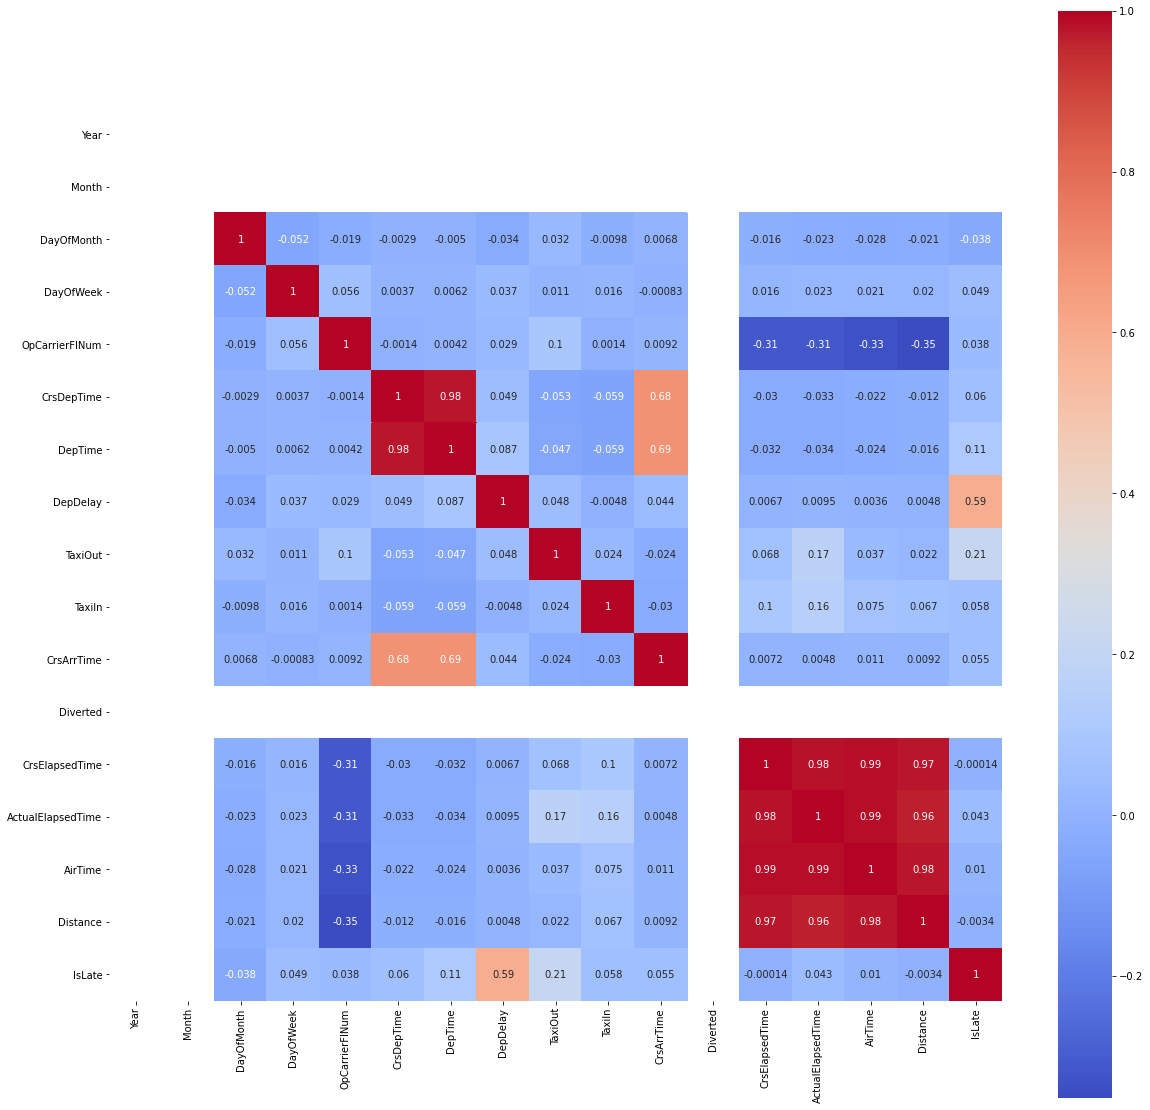

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, square=True, cmap="coolwarm", ax=ax);

# the scheduled time & actual time is strictly correlated -> should get the difference
# airtime & distance are also correlated with actual & schedule elapsed time

### Visualization numerical data based on IsLate label

__Numerical features:__ DepDelay, TaxiOut, TaxiIn, CrsElapsedTime, ActualElapsedTime, AirTime, Distance

__Categorical features:__ Year, Month, DayOfMonth, DayOfWeek, OpUniqueCarrier, TailNum, OpCarrierFlNum, Origin, Dest, CrsDepTime, DepTime, CrsArrTime, Diverted

In [25]:
from IPython.core.display import display, HTML

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<Figure size 720x504 with 0 Axes>

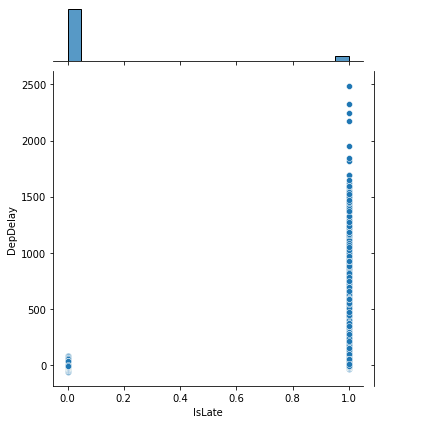

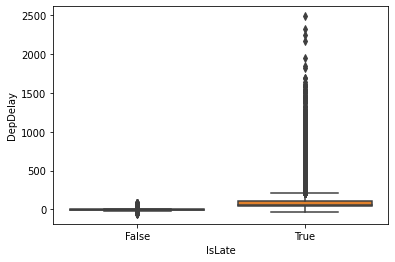

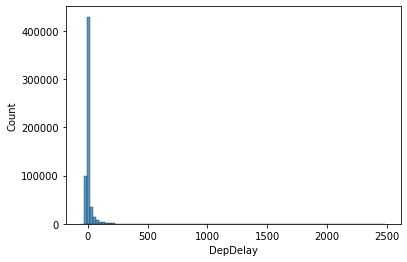

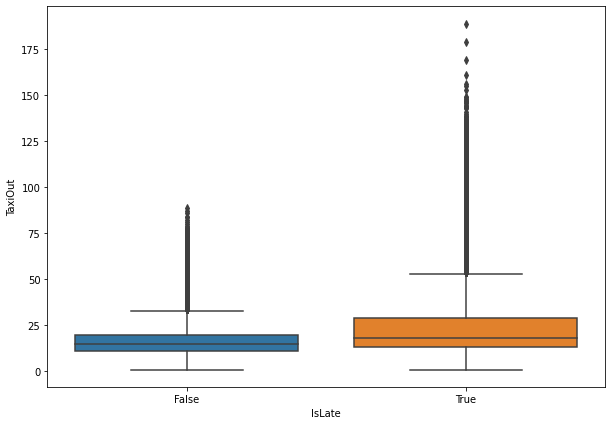

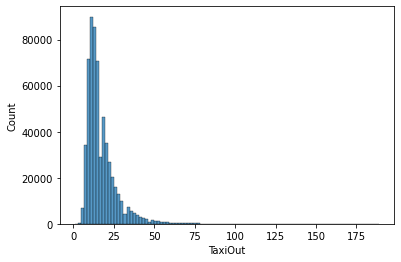

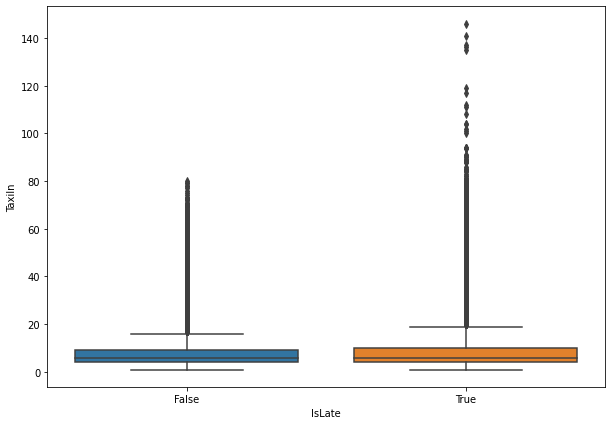

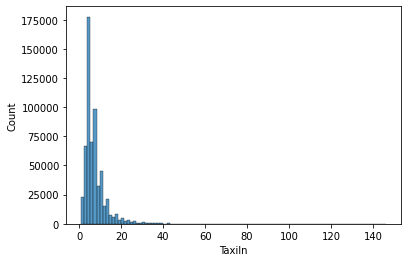

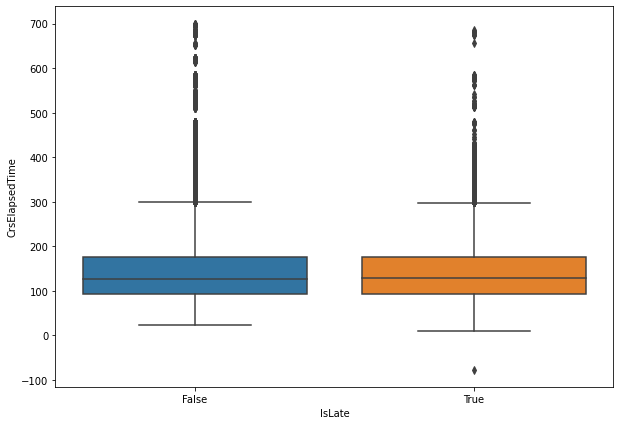

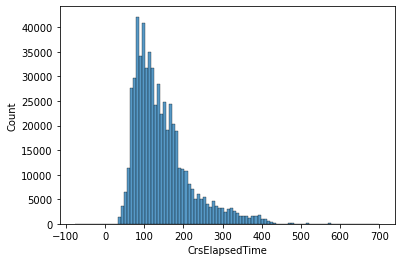

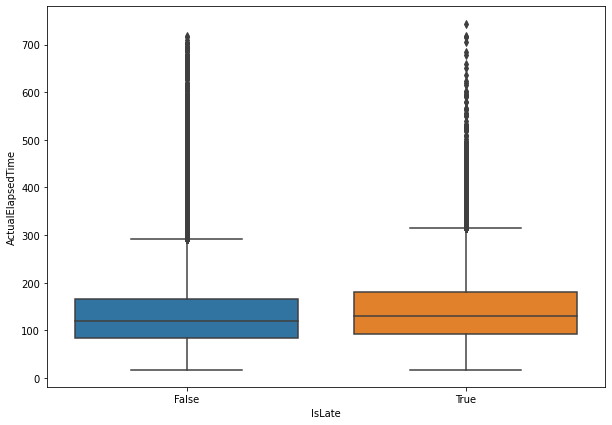

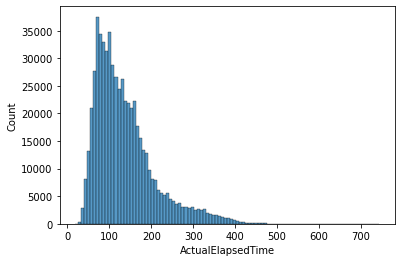

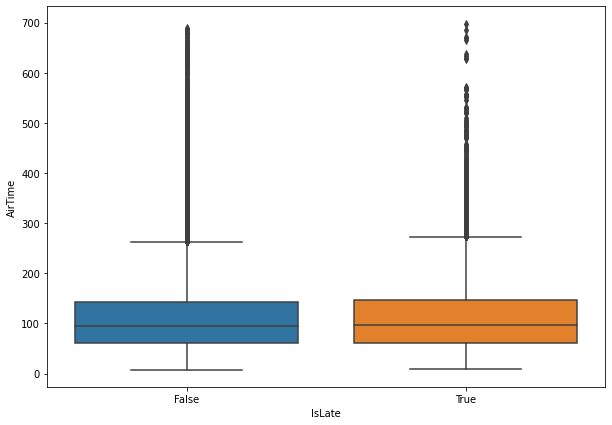

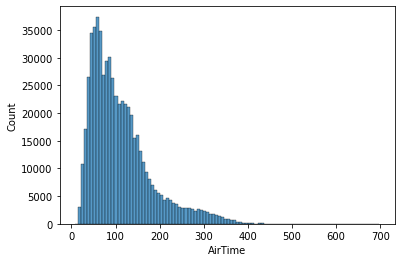

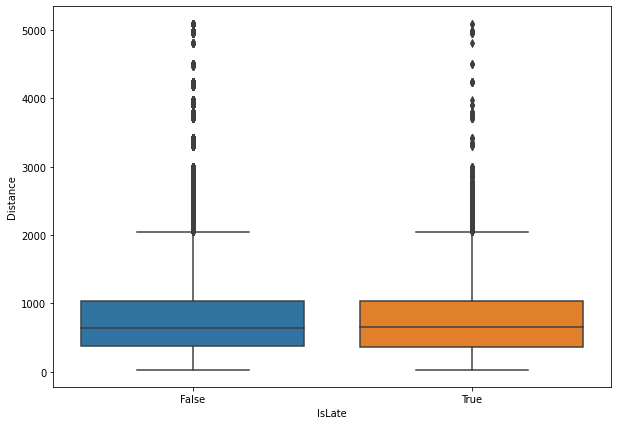

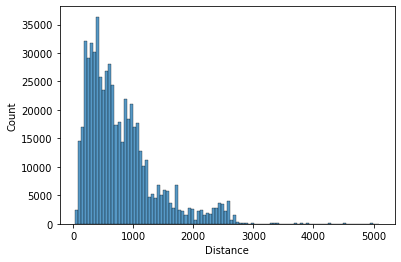

In [26]:
for column in ["DepDelay", "TaxiOut", "TaxiIn", "CrsElapsedTime", "ActualElapsedTime", "AirTime", "Distance"]:
    plt.figure(figsize=(10, 7))
    display(HTML(f"<h4>{column}</h4>"))
    
    if column == "DepDelay":
        sns.jointplot(data=df, x="IsLate", y=column);
        plt.show()
        
    sns.boxplot(data=df, x="IsLate", y=column);
    plt.show()
    
    sns.histplot(df[column], bins=100);
    plt.show()

# DepDelay: when the flights are late, we can see that the DepDelay feature ranges significantly from ~0 -> 2500
# Via data population, I can see that the features DepDelay, TaxiOut, TaxiIn affect the lateness directly
# Significantly, distance doesn't show any relation with IsLate

### Visualization categorical data based on IsLate label

In [27]:
# Year, Month, DayOfMonth, DayOfWeek, OpUniqueCarrier, TailNum, OpCarrierFlNum, Origin, Dest, CrsDepTime, DepTime, CrsArrTime, Diverted
df.groupby("DayOfMonth")["IsLate"].value_counts()

DayOfMonth  IsLate
1           False     16768
            True       1201
2           False     19011
            True       1483
3           False     18304
                      ...  
29          True        686
30          False     19520
            True       1147
31          False     19053
            True       1639
Name: IsLate, Length: 62, dtype: int64

### Feature engineering
- Vacation, holiday, last year
